<a href="https://colab.research.google.com/github/KazGet/Summer_prac_ML/blob/main/Summer_practies_2_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive; drive.mount('/content/drive')
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, RocCurveDisplay, roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, label_binarize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import Pipeline
!pip install missforest
from missforest import MissForest
!pip install optuna
import optuna
import shap
!pip install boruta
from boruta import BorutaPy

In [17]:
file = "/content/main.xlsx"
df = pd.read_excel(file, sheet_name=1)
df=df.drop([0,"Complete/CENSORED (Данные завершены/ вышел из тестирования)", "HisDiseasNumb", "date prior MI (Дата предыдущего инфаркта)", "date CABG", "date prior PCI",
            "Plaque texture", "Plaque echogenicity", "Hb","Troponine", "BNP",	"NTproBNP","hsCRP", "ALT", "AST", "GGT", "bilirubin", "Therapy anti diabetic drugs",
            "Therapy: digitalis", "Therapy other (specify)", "LM (%)", "LAD (%)", "RCA (%)","LCx (%)", "max%sten",	"FFR, LAD",	"FFR, RCA",	"FFA, Cx","iFR, LAD",
            "iFR, RCA","iFR, Cx", "EQL-5", "GLS RV stress", "6-min test, metres", "HbA1", 'Minutes Exercise', 'Sat O2 rest'], axis=1)

out_the_door=[
              'HR rest', 'SBP rest', 'DBP rest', 'MM rest', 'LVEDV rest', 'LVESV  rest', 'WMSI  rest', 'SV rest', 'LAD at rest', 'B-lines at rest', 'GLS rest',
              'LA vol rest', 'RA vol rest', 'E rest', 'A rest', 'DTE rest', "e' rest", "a' rest", "s' rest", 'TAPSE rest', 'S RV rest', 'MR rest', 'TR vel rest',
              'RVSP rest', 'GLS RV rest', 'Diast dysfunc rest', 'HR stress', 'SBP stress', 'DBP stress', 'LVEDV stress', 'LVESV stress', 'WMSI stress', 'SV stress',
              'LAD stress', 'B-lines stress', 'GLS stress-', 'LA vol  stress', 'RA vol stress', 'E  stress', 'A  stress', 'DTE stress', "e'  stress",
              "a'  stress", "s'  stress", 'TAPSE  stress', 'S RV  stress', 'MR  stress', 'TR vel  stress', 'RVSP  stress', 'Diast dysfunc  stress']
df=df.drop(out_the_door, axis=1)

df.drop(['Date of stress', 'Date Angiography', 'Data of birth', 'Last FU, Date (Дата последнего контрольного осмотра)'], axis=1, inplace=True)
df['LBBB (Блокада левой ножки пучка Гиса)'] = df['LBBB (Блокада левой ножки пучка Гиса)'].replace('RBBB', 0)
rbbb_mask = df['LBBB (Блокада левой ножки пучка Гиса)'] == 0
df['RBBB'] = rbbb_mask.astype(int)

categorical_features = ["ECG Rhythm (Ритм по ЭКГ)", "Smoker", "Stress Type", "Reason for Referral",
                        "Reason of Stress Stop","Peak ECG"]
df[categorical_features] = df[categorical_features].fillna("NaN").astype(str)


X = df.drop('Phenotype angio: 0 - анат-, гемо-, 1- анат-, гемо + (по ФРК, где есть), 2 - анат+, гемо -, 3 - анат+, гемо +', axis=1)
y = df['Phenotype angio: 0 - анат-, гемо-, 1- анат-, гемо + (по ФРК, где есть), 2 - анат+, гемо -, 3 - анат+, гемо +']

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_features] = encoder.fit_transform(X[categorical_features])
X.columns = X.columns.astype(str)
X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

/tmp/ipython-input-17-546648471.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['LBBB (Блокада левой ножки пучка Гиса)'] = df['LBBB (Блокада левой ножки пучка Гиса)'].replace('RBBB', 0)


In [18]:
# @title Удаление полупустых признаков и заполнение медианой
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.5].index
df_dropped = df.drop(cols_to_drop, axis=1)

X_dropped = df_dropped.drop('All sten range (Каранарография)', axis=1)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_dropped[categorical_features] = encoder.fit_transform(X_dropped[categorical_features])

imputer = SimpleImputer(strategy='median')
X_filled = imputer.fit_transform(X_dropped)
X_filled_data = pd.DataFrame(X_filled, columns=X_dropped.columns)

In [19]:
# @title Заполнение методом KNNImputer
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(X.select_dtypes(include=[np.number]))

imputer = KNNImputer(n_neighbors=10)
df_imputed_scaled = imputer.fit_transform(df_scaled)
df_KNN = scaler.inverse_transform(df_imputed_scaled)
df_final = pd.DataFrame(df_KNN, columns=X.columns)

In [20]:
# @title Заполнение пропусков методом Iterative Imputer
imputer = IterativeImputer(max_iter=25, random_state=0)
df_imputed = imputer.fit_transform(X)
df_MICE = pd.DataFrame(df_imputed, columns=X.columns)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [21]:
# @title Заполнение пропусков методом MissForest
mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_miss_forest = mf.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [09:36<00:00, 115.25s/it]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process

X_med: Компоненты, объясняющие 95% дисперсии = 59
df_KNN: Компоненты, объясняющие 95% дисперсии = 61
df_MICE: Компоненты, объясняющие 95% дисперсии = 59
df_MissForest: Компоненты, объясняющие 95% дисперсии = 61


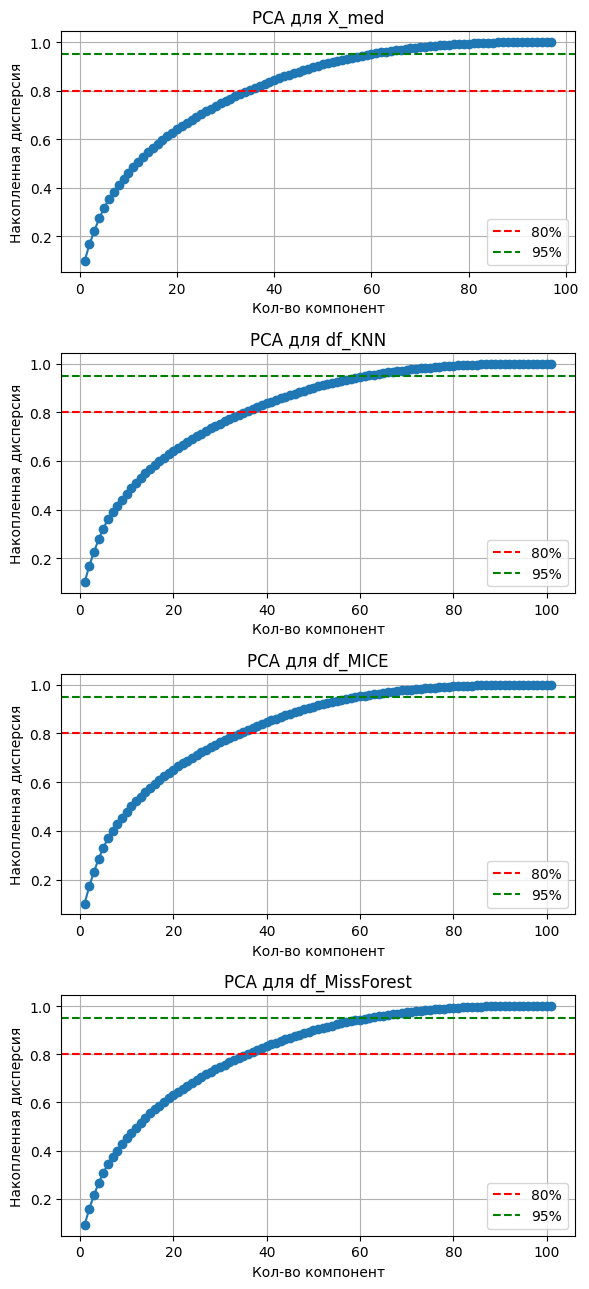

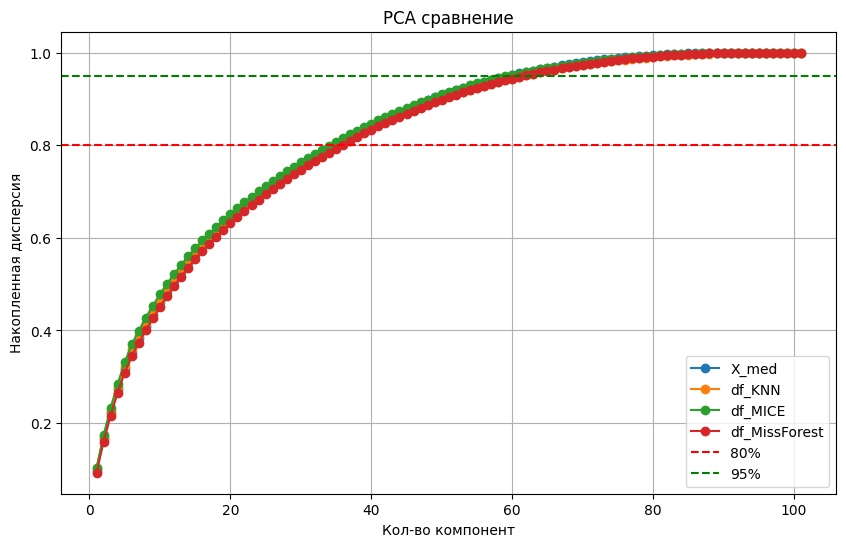

In [22]:
# @title PCA
fig, axes = plt.subplots(4, 1, figsize=(6, 13))

datasets = [
    ("X_med", X_filled_data),
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]


for ax, (name, data) in zip(axes, datasets):
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()


In [23]:
# @title Отбор признаков по матрице весов PCA
X_numeric = X_filled_data.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings_df = pd.DataFrame(
    data=pca.components_,
    columns=X_numeric.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
def get_most_important_features(component, loadings_df, n_features=1):
    pc_loadings = loadings_df.loc[component]
    most_important = pc_loadings.abs().sort_values(ascending=False).head(n_features)
    return loadings_df.loc[component, most_important.index]
    # return loadings_df.loc[component]

new_X = []
for i in range(1, 41):
  new_X.append(get_most_important_features(f'PC{i}', loadings_df))
  # print(get_most_important_features(f'PC{i}', loadings_df, n_features=1))

print(new_X)
# # Визуализируем нагрузки для первых 10 компонент
# plt.figure(figsize=(15, 8))
# sns.heatmap(loadings_df.head(10), cmap='vlag', annot=False) # annot=True, если признаков не слишком много
# plt.title('Тепловая карта нагрузок PCA (первые 10 компонент)')
# plt.show()

[ABCDE score+ECG+angina    0.252534
Name: PC1, dtype: float64, LVESVi at rest    0.295566
Name: PC2, dtype: float64, H2FPEF 2018 Score    0.311964
Name: PC3, dtype: float64, Body surface area    0.310523
Name: PC4, dtype: float64, Stress Type    0.260978
Name: PC5, dtype: float64, N_Vessel sign    0.225863
Name: PC6, dtype: float64, delta EF    0.306198
Name: PC7, dtype: float64, GLS reserve    0.369932
Name: PC8, dtype: float64, AF (Фибрилляция предсердий)    0.337094
Name: PC9, dtype: float64, Creatinine    0.339955
Name: PC10, dtype: float64, Cholesterol    0.276104
Name: PC11, dtype: float64, ECG range    0.270014
Name: PC12, dtype: float64, LPLD_Ch    0.293878
Name: PC13, dtype: float64, Therapy: sartan    0.346278
Name: PC14, dtype: float64, Smoker    0.269437
Name: PC15, dtype: float64, SI rest    0.390176
Name: PC16, dtype: float64, Glukosa    0.297476
Name: PC17, dtype: float64, slow flow    0.371327
Name: PC18, dtype: float64, SI stress    0.274272
Name: PC19, dtype: float64,

In [24]:
# @title Рекурсивное исключение признаков (Recursive Feature Elimination, RFE): Модель обучается на всех признаках, затем самый неважный удаляется, и процесс повторяется.
select_num = 12
selector_med = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_med.fit(X_filled, y)
selected_features_med = X_dropped.columns[selector_med.get_support()]
print("Отобранные признаки для данных, заполенными медианой: ")
print(selected_features_med.tolist())

selector_KNN = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_KNN.fit(df_KNN, y)
selected_features_KNN = X.columns[selector_KNN.get_support()]
print(f"Отобранные признаки для данных, заполенными методом ближайших соседей: ")
print(selected_features_KNN.tolist())

selector_MICE = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MICE.fit(df_MICE, y)
selected_features_MICE = X.columns[selector_MICE.get_support()]
print(f"Отобранные признаки для данных, заполенными методом итеративного заполнения: ")
print(selected_features_MICE.tolist())

selector_MissF = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MissF.fit(df_miss_forest, y)
selected_features_MissF = X.columns[selector_MissF.get_support()]
print(f"Отобранные признаки для данных, заполенными методом MissForest: ")
print(selected_features_MissF.tolist())

print("\nПересечение всех признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE) & set(selected_features_MissF))

Отобранные признаки для данных, заполенными медианой: 
['Angiography', 'N.vessels', 'N_Vessel sign', 'LAD range', 'Гемодин. 1, не значим. 0', 'Phenotype angio: 0 - анат-, гемо-, 1- анат-, гемо + (по ФРК, где есть), 2 - анат+, гемо -, 3 - анат+, гемо +', 'ESC Pre-test Probability', 'D WMSI', 'WMSI range', 'CFVR', 'СFVR range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма']
Отобранные признаки для данных, заполенными методом ближайших соседей: 
['N.vessels', 'N_Vessel sign', 'All sten range (Каранарография)', 'LAD range', 'FFR range', 'Гемодин. 1, не значим. 0', 'ESC Pre-test Probability', 'D WMSI', 'WMSI range', 'CFVR', 'СFVR range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма']
Отобранные признаки для данных, заполенными ме

In [25]:
print("\nПересечение первых трех множеств признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE))


Пересечение первых трех множеств признаков: 
{'LAD range', 'WMSI range', 'СFVR range', 'N_Vessel sign', 'Гемодин. 1, не значим. 0', 'D WMSI', 'N.vessels', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'CFVR'}


In [26]:
# @title Отбор признаков методом Boruta
dfrf = df_MICE
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

feat_selector = BorutaPy(
    estimator=rf,
    n_estimators='auto',
    max_iter=700,
    random_state=0,
    verbose=False
)

feat_selector.fit(dfrf.values, y.values)

selected_mask = feat_selector.support_
selected_features = dfrf.columns[selected_mask]

print("\nОтобранные признаки методом Boruta:")
print(selected_features.tolist())


Отобранные признаки методом Boruta:
['Angiography', 'Type Angiography', 'N.vessels', 'N_Vessel sign', 'All sten range (Каранарография)', 'slow flow', 'LAD range', 'FFR range', 'Гемодин. 1, не значим. 0', 'ESC Pre-test Probability', 'Stress Time', 'LVEDVi stress', 'delta EF', 'D WMSI', 'WMSI range', 'CFVR', 'СFVR range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']


In [27]:
# @title RFECV —  RFE с автоматическим выбором числа признаков через кросс-валидацию
df_test = df_MICE
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selector = RFECV(estimator=RandomForestClassifier(), step=1, cv=cv, scoring='accuracy', n_jobs=-1)
selector.fit(df_test, y)
selected_features = df_test.columns[selector.get_support()]
print("Оптимальное число признаков:", selector.n_features_)
print("Отобранные признаки:", selected_features.tolist())

Оптимальное число признаков: 11
Отобранные признаки: ['N_Vessel sign', 'All sten range (Каранарография)', 'slow flow', 'LAD range', 'FFR range', 'Гемодин. 1, не значим. 0', 'D WMSI', 'WMSI range', 'CFVR', 'СFVR range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма']


In [28]:
# @title Отбор признаков методом ANOVA: оценка стат. связи между каждым признаком и целевой переменной
datasets = {
    "медианой": (X_filled, X_dropped.columns),
    "KNN": (df_KNN, X.columns),
    "MICE": (df_MICE, X.columns),
    "MF": (df_miss_forest, X.columns),
}

selected_features_all = {}

for name, (X_data, feature_names) in datasets.items():
    selector = SelectKBest(score_func=f_classif, k=select_num)
    X_selected = selector.fit_transform(X_data, y)
    selected = feature_names[selector.get_support()]
    selected_features_all[name] = set(selected)
    print(f"Отобранные признаки с данными {name}:\n{list(selected)}")

Отобранные признаки с данными медианой:
['N.vessels', 'N_Vessel sign', 'LAD range', 'Гемодин. 1, не значим. 0', 'Phenotype angio: 0 - анат-, гемо-, 1- анат-, гемо + (по ФРК, где есть), 2 - анат+, гемо -, 3 - анат+, гемо +', 'D WMSI', 'WMSI range', 'СFVR range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Отобранные признаки с данными KNN:
['N.vessels', 'N_Vessel sign', 'All sten range (Каранарография)', 'LAD range', 'FFR range', 'Гемодин. 1, не значим. 0', 'D WMSI', 'WMSI range', 'СFVR range', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Отобранные признаки с данными MICE:
['N.vessels', 'N_Vessel sign', 'All sten range (Каранарография)', 'LAD range', 'Гемодин. 1, не значим. 0', 'D WMSI', 'WMSI range', 'СFVR range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [29]:
print("\nПересечение всех результатов (медиана ∩ KNN ∩ MICE):")
print(list(
    selected_features_all["медианой"]
    & selected_features_all["KNN"]
    & selected_features_all["MICE"]
))


Пересечение всех результатов (медиана ∩ KNN ∩ MICE):
['ABCDE score', 'LAD range', 'WMSI range', 'СFVR range', 'N_Vessel sign', 'Гемодин. 1, не значим. 0', 'D WMSI', 'ABCDE score+ECG+angina', 'N.vessels', 'ABCDE score+ECG']


In [30]:
# @title Отбор по LassoCV
def run_lasso_selection(X_source, y, name, feature_names):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso_cv', LassoCV(cv=5, max_iter=10000))
    ])

    pipeline.fit(X_source, y)
    best_alpha = pipeline.named_steps['lasso_cv'].alpha_

    print(f"\n{name}: наилучшее значение alpha = {best_alpha:.4f}")

    lasso = Lasso(alpha=best_alpha, max_iter=10000)
    X_scaled = StandardScaler().fit_transform(X_source)
    lasso.fit(X_scaled, y)

    non_zero_coefs = np.where(lasso.coef_ != 0)[0]
    selected = feature_names[non_zero_coefs]

    print(f"\nВыбранные признаки для {name}:\n", selected.tolist())
    return set(selected)

features_median = run_lasso_selection(X_filled, y, "Median", X_dropped.columns)
features_knn    = run_lasso_selection(df_KNN, y, "KNN", X.columns)
features_mice   = run_lasso_selection(df_MICE, y, "MICE", X.columns)
features_mf     = run_lasso_selection(df_miss_forest, y, "MissForest", X.columns)

print("\nПересечение всех признаков:")
intersection = features_median & features_knn & features_mice & features_mf
print(intersection)



Median: наилучшее значение alpha = 0.0012

Выбранные признаки для Median:
 ['Phenotype angio: 0 - анат-, гемо-, 1- анат-, гемо + (по ФРК, где есть), 2 - анат+, гемо -, 3 - анат+, гемо +']

KNN: наилучшее значение alpha = 0.0226

Выбранные признаки для KNN:
 ['Prior MI ( Перенесённый инфаркт миокарда)', 'Therapy insulin', 'Angiography', 'Type Angiography', 'N_Vessel sign', 'All sten range (Каранарография)', 'LAD range', 'FFR range', 'Гемодин. 1, не значим. 0', 'Peak ECG', 'B range', 'LV contractile reserve', 'CFVR']

MICE: наилучшее значение alpha = 0.0229

Выбранные признаки для MICE:
 ['Hypertension (Артериальная гипертензия)', 'Obesity (Ожирение)', 'Prior MI ( Перенесённый инфаркт миокарда)', 'Angiography', 'Type Angiography', 'N.vessels', 'N_Vessel sign', 'All sten range (Каранарография)', 'LAD range', 'Гемодин. 1, не значим. 0', 'Peak ECG', 'RAVI rest', 'LVESVi stress', 'delta EF', 'B range', 'LV contractile reserve', 'CFVR']

MissForest: наилучшее значение alpha = 0.0267

Выбранн

In [32]:
# @title Объединение методов

#Удалим признаки с >50% пропусков
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.4].index
df_dropped = df.drop(cols_to_drop, axis=1)
X_d = df_dropped.drop('All sten range (Каранарография)', axis=1)
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_d[categorical_features] = encoder.fit_transform(X_d[categorical_features])

#Используем IterativeImputer для заполнения оставшихся признаков
mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_after_MF = mf.fit_transform(X_d)

imputer = IterativeImputer(max_iter=20, random_state=0)
df_after_MICE = imputer.fit_transform(X_d)
df_after_MICE = pd.DataFrame(df_after_MICE, columns=X_d.columns)

#Масшитабируем
X_numeric = df_after_MICE.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

X_numeric_ = df_after_MF.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled_ = scaler.fit_transform(X_numeric_)

#Сделаем отбор по методу RFE
selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled, y)
selected_features_MICE = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MICE: ")
print(selected_features_MICE.tolist())

selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled_, y)
selected_features_MF = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MF: ")
print(selected_features_MF.tolist())

#Сделаем отбор методом ANOVA
selector_ANOVA = SelectKBest(score_func=f_classif, k=select_num)
X_anova = selector_ANOVA.fit_transform(X_scaled, y)

selector_ANOVA_ = SelectKBest(score_func=f_classif, k=select_num)
X_anova_ = selector_ANOVA_.fit_transform(X_scaled_, y)

scores = selector_ANOVA.scores_
p_values = selector_ANOVA.pvalues_

scores = selector_ANOVA_.scores_
p_values = selector_ANOVA_.pvalues_

selected_featuresMICE = X_d.columns[selector_ANOVA.get_support()]
print(f"\nОтобранные признаки методом ANOVA:\n {list(selected_featuresMICE)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MICE) & set(selected_featuresMICE))

selected_featuresMF = X_d.columns[selector_ANOVA_.get_support()]
print(f"\nОтобранные признаки методом ANOVA (MF):\n {list(selected_featuresMF)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MF) & set(selected_featuresMF))

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [07:47<00:00, 93.49s/it]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process 

Отобранные признаки методом RFE+MICE: 
['Type Angiography', 'N.vessels', 'N_Vessel sign', 'LAD range', 'Гемодин. 1, не значим. 0', 'Phenotype angio: 0 - анат-, гемо-, 1- анат-, гемо + (по ФРК, где есть), 2 - анат+, гемо -, 3 - анат+, гемо +', 'LVEDVi stress', 'D WMSI', 'WMSI range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score', 'ABCDE score+ECG']
Отобранные признаки методом RFE+MF: 
['Creatinine', 'Creatinine clearance', 'Therapy: calcium antagonist', 'Therapy: nitrate', 'Therapy: aspirin', 'Therapy: other antiplatelet agent', 'Therapy: anticoagulant', 'delta EF', 'E/A stress', "E/e' stress", 'Diast dysfunc  range', 'RBBB']

Отобранные признаки методом ANOVA:
 ['Angiography', 'Type Angiography', 'N.vessels', 'N_Vessel sign', 'LAD range', 'Phenotype angio: 0 - анат-, гемо-, 1- анат-, гемо + (по ФРК, где есть), 2 - анат+, гемо -, 3 - анат+, 

In [33]:
print(set(selected_features_MICE) & set(selected_featuresMICE) & set(selected_features_MF) & set(selected_featuresMF))

set()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:30:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.945054945054945
Recall: 0.9485324302134647

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.94      1.00      0.97        17
           2       0.90      0.90      0.90        21
           3       0.93      0.93      0.93        29

    accuracy                           0.95        91
   macro avg       0.95      0.95      0.95        91
weighted avg       0.95      0.95      0.95        91


Confusion matrix:
 [[23  1  0  0]
 [ 0 17  0  0]
 [ 0  0 19  2]
 [ 0  0  2 27]]


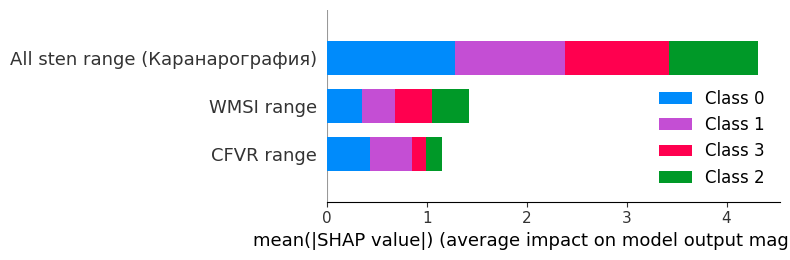

In [34]:
# @title XGBoost

optimal_cols = ['All sten range (Каранарография)', 'WMSI range', 'СFVR range']


X_boost=X[optimal_cols]

X_train, X_test, y_train, y_test = train_test_split(X_boost, y, stratify=y, random_state=42, test_size=0.2)

params = {'max_depth': 6, 'learning_rate': 0.38830158686351, 'n_estimators': 188, 'min_child_weight': 2, 'gamma': 2.5968539032497118, 'subsample': 0.9070492409605632, 'colsample_bytree': 0.7562826912266845, 'reg_alpha': 1.319550703563934, 'reg_lambda': 5.973831576646422, 'scale_pos_weight': 1.1822476929190666}

model = XGBClassifier(**params)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)  # shape (n_samples, n_classes)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Recall: по умолчанию будет брать average='binary' — это ошибка в многоклассовой задаче
print("Recall:", recall_score(y_test, y_pred, average='macro'))

# Полный отчет
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Матрица ошибок
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

explainer = shap.Explainer(model, X_boost)
shap_values = explainer(X_boost)
shap.summary_plot(shap_values, X_boost)

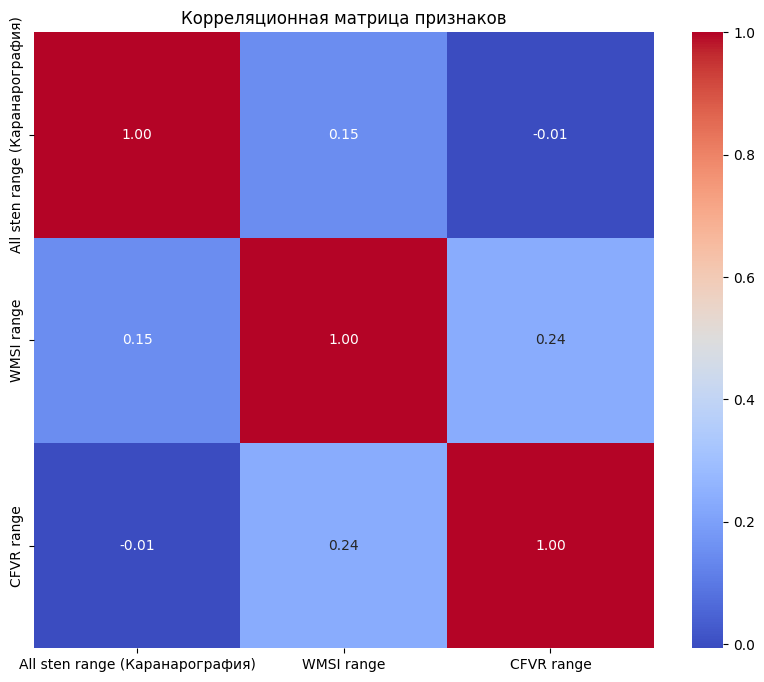

In [36]:
# @title Матрица корреляции для отобранных признаков
corr_matrix = X_boost.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица признаков')
plt.show()

df_KNN: Компоненты, объясняющие 95% дисперсии = 2
df_MICE: Компоненты, объясняющие 95% дисперсии = 2
df_MissForest: Компоненты, объясняющие 95% дисперсии = 2


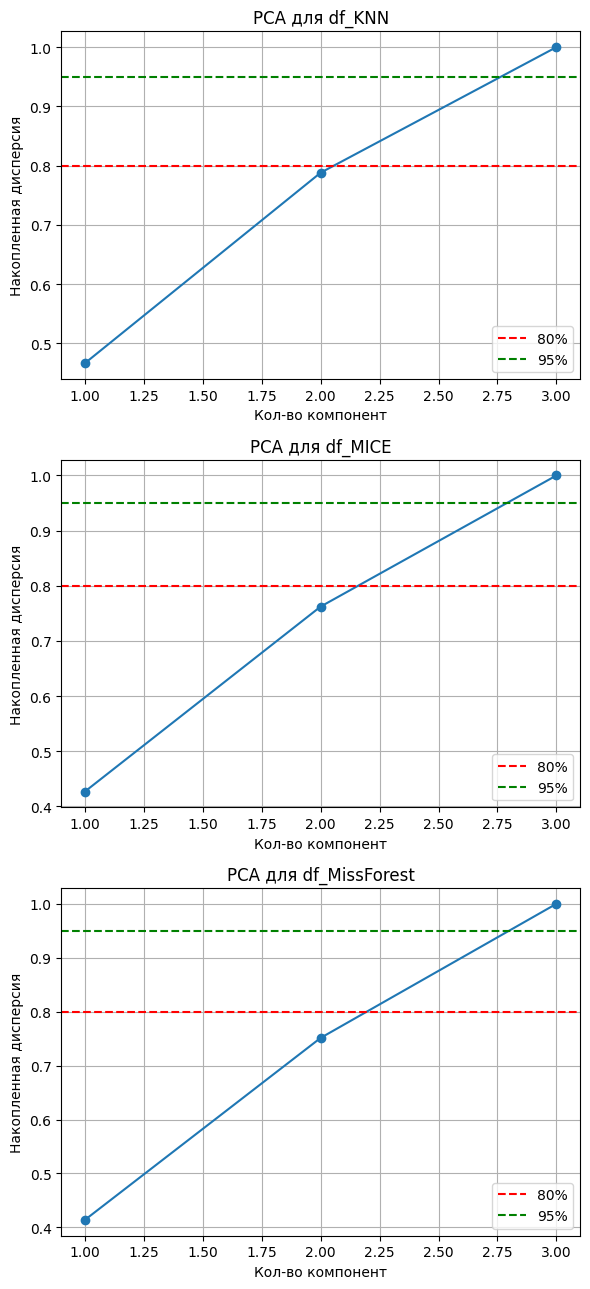

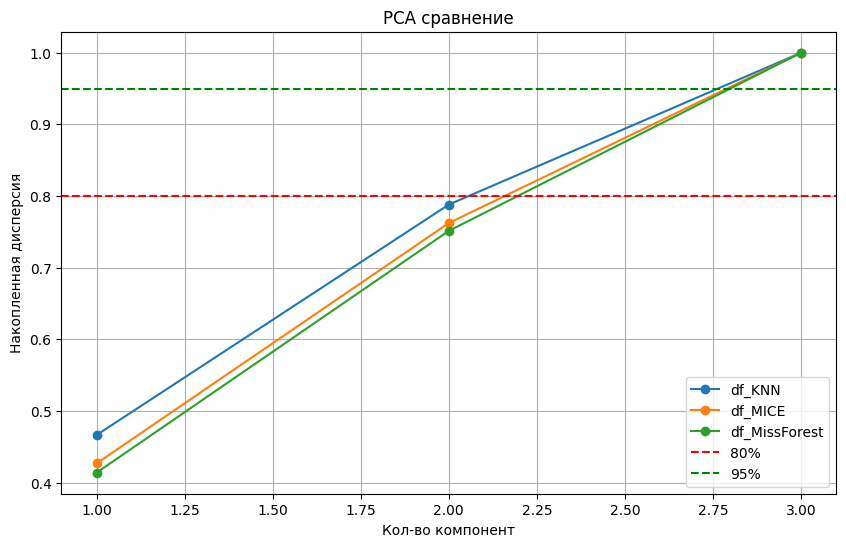

In [37]:
# @title PCA для отобранных признаков
fig, axes = plt.subplots(3, 1, figsize=(6, 13))

datasets = [
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]

for ax, (name, data) in zip(axes, datasets):
    data=data[optimal_cols]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    data=data[optimal_cols]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()
